In [125]:
import numpy as np
import pandas as pd
import auxil_ML as aux
from matplotlib import pyplot
import os

import plotting

In [126]:
def get_prec_recall(cat, n, thresholds, label='PSR'):
    df = cat_dfs[cat][n]
    cat_ = cat.split('-')[0]
    assoc_mask = df['Category_%s' % cat_] != 'UNAS'
    true_mask = df['Category_%s' % cat_] == label
    true_mask &= assoc_mask
    res_dict = {}
    res_dict['prec'] = np.zeros_like(thresholds)
    res_dict['recall'] = np.zeros_like(thresholds)
    res_dict['true_positive'] = np.zeros_like(thresholds)
    res_dict['positive'] = np.zeros_like(thresholds)
    res_dict['true'] = np.zeros_like(thresholds)
    for i, thres in enumerate(thresholds):
        positive_mask = np.prod(df[cols] > thres, axis=1).astype(bool)
        positive_mask &= assoc_mask
        res_dict['true_positive'][i] = np.sum(true_mask & positive_mask)
        res_dict['positive'][i] = np.sum(positive_mask)
        res_dict['true'][i] = np.sum(true_mask)
        # precision = true positive / positive
        res_dict['prec'][i] = res_dict['true_positive'][i] / res_dict['positive'][i]
        # recall = true positive / true
        res_dict['recall'][i] = res_dict['true_positive'][i] / res_dict['true'][i]
    
    return res_dict


def get_prec_recall_3vs4(cat_dfs, n, thresholds, index_4fgl, label='PSR'):
    cat_df_4fgl = cat_dfs['4FGL-DR2'][2].loc[index_4fgl]
    # unassociated sources in 3FGL, which have associations in 4FGL
    index_3fgl = list(cat_df_4fgl['ASSOC_FGL'].loc[index_4fgl])
    cat_df_3fgl = cat_dfs['3FGL'][n].loc[index_3fgl]
    true_mask = np.array(cat_df_4fgl['Category_4FGL'] == label)
    res_dict = {}
    res_dict['prec'] = np.zeros_like(thresholds)
    res_dict['recall'] = np.zeros_like(thresholds)
    res_dict['true_positive'] = np.zeros_like(thresholds)
    res_dict['positive'] = np.zeros_like(thresholds)
    res_dict['true'] = np.zeros_like(thresholds)
    for i, thres in enumerate(thresholds):
        positive_mask = np.prod(cat_df_3fgl[cols] > thres, axis=1).astype(bool)
        res_dict['true_positive'][i] = np.sum(true_mask & positive_mask)
        res_dict['positive'][i] = np.sum(positive_mask)
        res_dict['true'][i] = np.sum(true_mask)
        # precision = true positive / positive
        res_dict['prec'][i] = res_dict['true_positive'][i] / res_dict['positive'][i]
        # recall = true positive / true
        res_dict['recall'][i] = res_dict['true_positive'][i] / res_dict['true'][i]
    
    return res_dict

In [127]:
cat_dfs = {}
cats = ['3FGL', '4FGL-DR2']
# initialize the dictionary of catalogs
for cat in cats:
    cat_dfs[cat] = {}

# load dictionaries
for cat in cats:
    cat_dfs[cat] = {}
    for n in [2, 3]:
        cat_fn = '../SOM/%s_prob_catalog_%iclasses.csv' % (cat, n)
        cat_dfs[cat][n] = pd.read_csv(cat_fn, index_col=0)


In [138]:
cat = '4FGL-DR2' # '3FGL', '4FGL-DR2'
label = 'PSR' # 'PSR', 'OTHER'

algs = ['RF', 'LR', 'BDT', 'NN']
algs_O = ['%s_O' % alg for alg in algs]
algs_all = algs + algs_O

cols = ['%s_%s' % (label, alg) for alg in algs_all]
thresholds = np.arange(0.1, 0.92, 0.03)
if label == 'OTHER':
    ncl = [3]
else:
    ncl = [3, 2]
plotting.setup_figure_pars();
save_plots = 1
ls_dict = {'prec':{2:'-.', 3:'-'}, 'recall':{2:':', 3:'--'}}
plots_folder = 'plots/thresholds'
if not os.path.isdir(plots_folder):
    os.makedirs(plots_folder)

In [139]:
# find all associated sources in 4FGL, which are also associated to unassociated 3FGL sources
cat_df_4fgl = cat_dfs['4FGL-DR2'][2]
cat_df_3fgl = cat_dfs['3FGL'][2]
assoc_3FGL_in_4FGL_mask = [(type(name) is str) for name in list(cat_df_4fgl['ASSOC_FGL'])]
index0 = [name for name in cat_df_4fgl.index[assoc_3FGL_in_4FGL_mask] 
         if cat_df_4fgl['ASSOC_FGL'].loc[name].startswith('3FGL') 
         and cat_df_4fgl['ASSOC_FGL'].loc[name] in cat_df_3fgl.index
         and cat_df_3fgl['Category_3FGL'].loc[cat_df_4fgl['ASSOC_FGL'].loc[name]] == 'UNAS']

# subselect sources, which are associated
index_4fgl = [name for name in index0 if cat_df_4fgl['Category_4FGL'].loc[name] != 'UNAS']


save figure to file: plots/thresholds/thresholds_prec_recall_4FGL-DR2_PSR.pdf


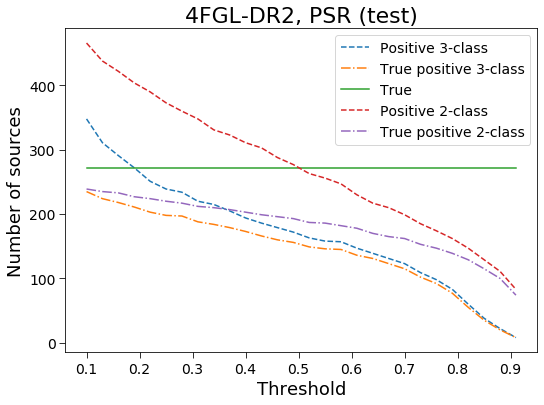

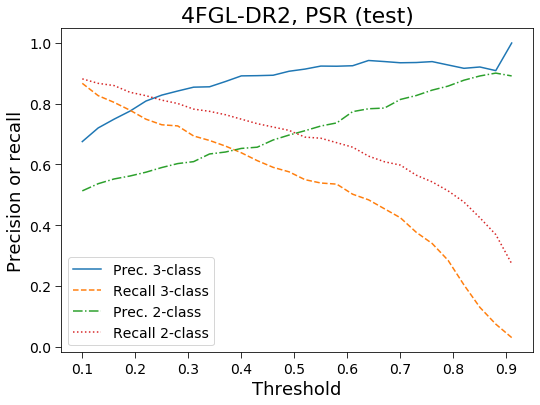

In [140]:
pyplot.figure()
for n in ncl:
    res_dict = get_prec_recall(cat, n, thresholds, label=label)
    #print(n, res_dict)
    if n == 2:
        pyplot.plot(thresholds, res_dict['true'], ls='-', 
                    label='True')
    pyplot.plot(thresholds, res_dict['positive'], ls='--', 
                label='Positive %i-class' % n)
    pyplot.plot(thresholds, res_dict['true_positive'], ls='-.', 
                label='True positive %i-class' % n)
pyplot.xlabel('Threshold')
pyplot.ylabel('Number of sources')
pyplot.legend()
pyplot.title('%s, %s (test)' % (cat, label))
    
pyplot.figure()
for n in ncl:
    res_dict = get_prec_recall(cat, n, thresholds)
    pyplot.plot(thresholds, res_dict['prec'], ls=ls_dict['prec'][n], 
                label='Prec. %i-class' % n)
    pyplot.plot(thresholds, res_dict['recall'], ls=ls_dict['recall'][n], 
                label='Recall %i-class' % n)
pyplot.xlabel('Threshold')
pyplot.ylabel('Precision or recall')
pyplot.legend()
pyplot.title('%s, %s (test)' % (cat, label))
if save_plots:
    fn = '%s/thresholds_prec_recall_%s_%s.pdf' % (plots_folder, cat, label)
    print('save figure to file: %s' % fn)
    pyplot.savefig(fn)

if cat == '3FGL':
    pyplot.figure()
    for n in ncl:
        res_dict = get_prec_recall_3vs4(cat_dfs, n, thresholds, index_4fgl, label=label)
        pyplot.plot(thresholds, res_dict['prec'], ls=ls_dict['prec'][n],
                    label='Prec. %i-class' % n)
        pyplot.plot(thresholds, res_dict['recall'], ls=ls_dict['recall'][n],
                    label='Recall %i-class ' % n)
    pyplot.xlabel('Threshold')
    pyplot.ylabel('Precision or recall')
    pyplot.legend()
    pyplot.title('%s, %s (3FGL vs 4FGL)' % (cat, label))
    if save_plots:
        fn = '%s/thresholds_prec_recall_3FGL_vs_4FGL-DR2_%s.pdf' % (plots_folder, label)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)

